Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pearson correlation (FG value vs daily sum PnL): -0.4527


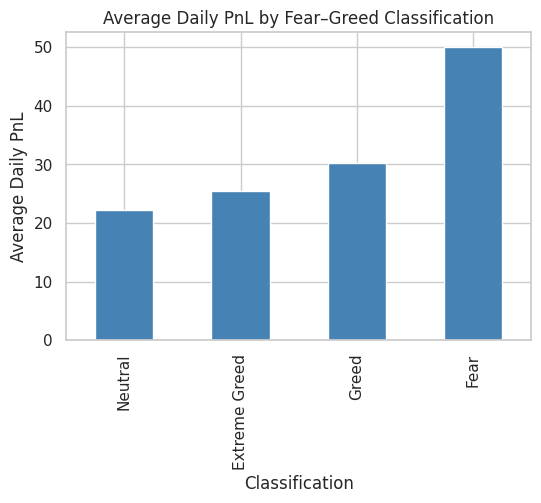

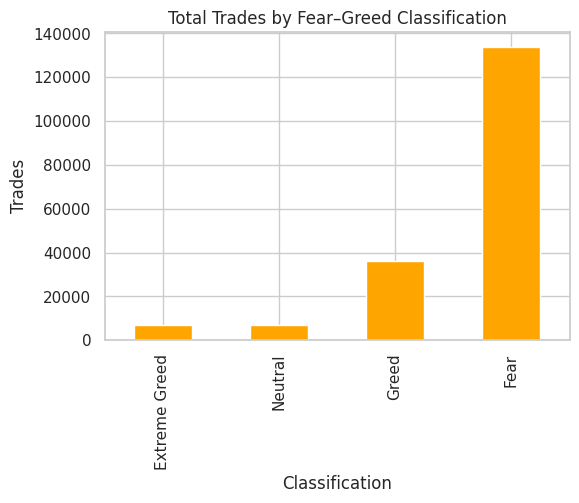

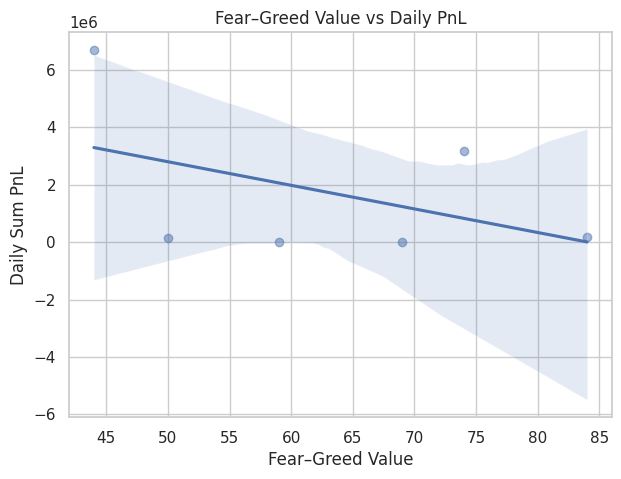

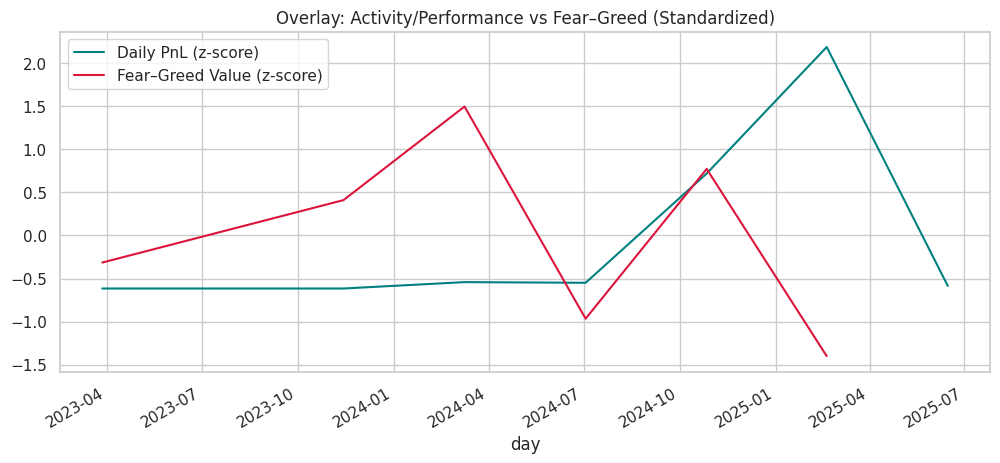

                        day  trades       sum_pnl    avg_pnl  buy_ratio  \
0 2023-03-28 00:00:00+00:00       3  0.000000e+00   0.000000   1.000000   
1 2023-11-14 00:00:00+00:00    1045  1.555034e+02   0.148807   0.469856   
2 2024-03-09 00:00:00+00:00    6962  1.769655e+05  25.418772   0.484200   
3 2024-07-03 00:00:00+00:00    7141  1.587424e+05  22.229713   0.490828   
4 2024-10-27 00:00:00+00:00   35241  3.189461e+06  90.504272   0.423569   
5 2025-02-19 00:00:00+00:00  133871  6.699925e+06  50.047622   0.493617   
6 2025-06-15 00:00:00+00:00   26961  7.170935e+04   2.659744   0.531063   

   value classification  
0   59.0          Greed  
1   69.0          Greed  
2   84.0  Extreme Greed  
3   50.0        Neutral  
4   74.0          Greed  
5   44.0           Fear  
6    NaN            NaN  


In [1]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
FG_PATH   = '/content/drive/MyDrive/ds_UtsavThakur/fear_greed_index.csv'
HIST_PATH = '/content/drive/MyDrive/ds_UtsavThakur/historical_data.csv'
def standardize_cols(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
        .str.replace(r'[^0-9a-zA-Z_]', '', regex=True)
        .str.lower()
    )
    return df

def pick_col(df, preferred_exact=None, contains_any=None):
    cols = list(df.columns)
    if preferred_exact and preferred_exact in df.columns:
        return preferred_exact
    if contains_any:
        for c in cols:
            name = c.lower()
            if any(sub in name for sub in contains_any):
                return c
    return None

def to_datetime_safely(s):

    s_clean = pd.to_numeric(s, errors='coerce')
    if s_clean.notna().any():

        use_ms = (s_clean.dropna().median() > 1e12)
        unit = 'ms' if use_ms else 's'
        return pd.to_datetime(s_clean, unit=unit, utc=True)

    return pd.to_datetime(s, errors='coerce', utc=True)

def safe_mean(series):
    try:
        return pd.to_numeric(series, errors='coerce').mean()
    except Exception:
        return np.nan


fg = pd.read_csv(FG_PATH, low_memory=False)
hist = pd.read_csv(HIST_PATH, low_memory=False)

fg = standardize_cols(fg)
hist = standardize_cols(hist)


fg_date_col = pick_col(fg, preferred_exact='date', contains_any=['date','time','timestamp'])
if fg_date_col is None:
    raise ValueError("Could not find a date/timestamp column in Fear–Greed file.")

if fg_date_col == 'date':
    fg['fg_datetime'] = pd.to_datetime(fg['date'], errors='coerce', utc=True)
else:
    fg['fg_datetime'] = to_datetime_safely(fg[fg_date_col])


hist_ts_col = pick_col(hist, preferred_exact='timestamp', contains_any=['timestamp','time','date'])
if hist_ts_col is None:
    raise ValueError("Could not find a timestamp/date column in historical data.")

hist['trade_datetime'] = to_datetime_safely(hist[hist_ts_col])


fg['day'] = fg['fg_datetime'].dt.floor('D')
hist['day'] = hist['trade_datetime'].dt.floor('D')

pnl_col = pick_col(hist, contains_any=['pnl'])
side_col = pick_col(hist, preferred_exact='side', contains_any=['side'])
lev_col  = pick_col(hist, preferred_exact='leverage', contains_any=['leverage'])
fee_col  = pick_col(hist, preferred_exact='fee', contains_any=['fee'])

agg_dict = {'trades': ('day', 'size')}

if pnl_col:
    agg_dict['sum_pnl'] = (pnl_col, lambda x: pd.to_numeric(x, errors='coerce').sum())
    agg_dict['avg_pnl'] = (pnl_col, lambda x: pd.to_numeric(x, errors='coerce').mean())

if lev_col:
    agg_dict['avg_leverage'] = (lev_col, safe_mean)

if fee_col:
    agg_dict['sum_fees'] = (fee_col, lambda x: pd.to_numeric(x, errors='coerce').sum())

if side_col:

    def buy_ratio(s):
        s = s.astype(str).str.upper()
        return (s == 'BUY').mean()
    agg_dict['buy_ratio'] = (side_col, buy_ratio)

daily_hist = (
    hist.dropna(subset=['day'])
        .groupby('day')
        .agg(**agg_dict)
        .reset_index()
)


fg_value_col = pick_col(fg, preferred_exact='value', contains_any=['value','index'])
fg_class_col = pick_col(fg, preferred_exact='classification', contains_any=['class'])

fg_keep = ['day']
if fg_value_col: fg_keep.append(fg_value_col)
if fg_class_col: fg_keep.append(fg_class_col)
fg_small = fg[fg_keep].dropna(subset=['day']).drop_duplicates('day')


df = pd.merge(daily_hist, fg_small, on='day', how='left')


if 'sum_pnl' in df.columns and fg_value_col:
    corr = df['sum_pnl'].corr(pd.to_numeric(df[fg_value_col], errors='coerce'))
    print(f"Pearson correlation (FG value vs daily sum PnL): {corr:.4f}")
else:
    print("PnL or FG numeric value missing; skipping correlation.")


if 'avg_pnl' in df.columns and fg_class_col:
    plt.figure(figsize=(6,4))
    (df.groupby(fg_class_col)['avg_pnl']
       .mean()
       .sort_values()
       .plot(kind='bar', color='steelblue'))
    plt.title('Average Daily PnL by Fear–Greed Classification')
    plt.ylabel('Average Daily PnL')
    plt.xlabel('Classification')
    plt.show()


if fg_class_col:
    plt.figure(figsize=(6,4))
    (df.groupby(fg_class_col)['trades']
       .sum()
       .sort_values()
       .plot(kind='bar', color='orange'))
    plt.title('Total Trades by Fear–Greed Classification')
    plt.ylabel('Trades')
    plt.xlabel('Classification')
    plt.show()

if 'sum_pnl' in df.columns and fg_value_col:
    plt.figure(figsize=(7,5))
    sns.regplot(
        data=df,
        x=pd.to_numeric(df[fg_value_col], errors='coerce'),
        y='sum_pnl',
        lowess=False,
        scatter_kws={'alpha':0.5}
    )
    plt.xlabel('Fear–Greed Value')
    plt.ylabel('Daily Sum PnL')
    plt.title('Fear–Greed Value vs Daily PnL')
    plt.show()


plt.figure(figsize=(12,5))
ax = None
if 'sum_pnl' in df.columns:
    s1 = (df.set_index('day')['sum_pnl']).astype('float')
    s1 = (s1 - s1.mean())/s1.std(ddof=0)
    ax = s1.plot(label='Daily PnL (z-score)', color='teal')
else:
    s1 = (df.set_index('day')['trades']).astype('float')
    s1 = (s1 - s1.mean())/s1.std(ddof=0)
    ax = s1.plot(label='Daily Trades (z-score)', color='teal')

if fg_value_col:
    s2 = pd.to_numeric(df.set_index('day')[fg_value_col], errors='coerce')
    s2 = (s2 - s2.mean())/s2.std(ddof=0)
    s2.plot(ax=ax, label='Fear–Greed Value (z-score)', color='crimson')

plt.title('Overlay: Activity/Performance vs Fear–Greed (Standardized)')
plt.legend()
plt.show()

out_cols = ['day','trades']
if 'sum_pnl' in df.columns: out_cols.append('sum_pnl')
if 'avg_pnl' in df.columns: out_cols.append('avg_pnl')
if 'avg_leverage' in df.columns: out_cols.append('avg_leverage')
if 'buy_ratio' in df.columns: out_cols.append('buy_ratio')
if fg_value_col: out_cols.append(fg_value_col)
if fg_class_col: out_cols.append(fg_class_col)

summary = df[out_cols].sort_values('day').tail(20)
print(summary.head(10))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
